# Playing with a small DB and storage

Setup visualization libraries

In [1]:
def displaySectionCaption(caption, color='coral'):
  html_string = f'<hr><strong><p style="color:{color};font-size:16px;">{caption}</p.</strong>'
  display(HTML(html_string))

We study a simplified IO model for HDDs and SSDs in CMPE-138. The model will work well in practice, for our query optimzation and data layout problems. 

In [2]:
import math
from math import ceil, log

# We'll use MBs -- for basic i to MBs
(MB, GB, TB, KB, Bytes) = (1.0, 1024.0, 1024.0*1024.0,
                           1.0/1024.0, 1.0/(1024.0*1024))

# 64 MB-Blocks (default)
PageSizeMB = 64.0*MB
size_of_types = {'int64': 8, 'int32': 4, 'double': 8, 'char': 1} # in bytes

class IOdevice:
  def __init__(self, accessTime, scanSpeed, C_w):
    self.C_r = 1.0  # Cost of reads
    self.C_w = C_w  # Cost of writes relative to reads
    self.accessTime = accessTime
    self.scanSpeed = scanSpeed

  # Read costs: Simple IOcost model using Access time + Scan speeds
  def read_pages_cost(self, numPages):
    # Assume you need to read full pages. (i.e., no partial pages)
    numPages = math.ceil(numPages)
    tsecs = numPages*self.accessTime  # time to access
    tsecs += numPages*PageSizeMB/self.scanSpeed # time to scan
    return (tsecs)

  def write_pages_cost(self, numPages):
    return self.C_w*self.read_pages_cost(numPages)

# Example IO devices in 2024
# Access and Scan speeds in [seconds, MBps], Cw cost of write vs reads.
ram1 = IOdevice(100*pow(10, -9), 100.0*1024, 1.0)
ssd1 = IOdevice(10*pow(10, -6), 5.0*1024, 1.0) # 10 microsecs, 5GBps
hdd1 = IOdevice(10*pow(10, -3), 100.0, 1.0) # 10 millissecs, 100 MBps
# machine to machine over network (modeling a network as an IO device)
m2m1 = IOdevice(10*pow(10, -6), 5.0*1024, 1.0) # 1 micro, 5 GBps

IOdevices1 = {'HDD': hdd1, 'SSD': ssd1, 'RAM': ram1}

In [3]:
"""
Basic physical table
"""
class Table:
  def __init__(self, sizeInMBs, rowSize):
    self.sizeInMBs = sizeInMBs
    self.rowSize = rowSize
    self.numRows = ceil(self.sizeInMBs/self.rowSize)

    # self.numTuples = numTuples
    self.isSorted = False
    self.isHPed = False

  # P(R) -- number of Pages for table
  def P(self):
    P = ceil(self.sizeInMBs/PageSizeMB)
    return P
  def RowSize(self):
    return self.rowSize
  def T(self):
    return self.numRows
  def SizeInMBs(self):
    return self.sizeInMBs

  # Keeping track of is table sorted, HPed, or neither (default)
  def Sort(self):
    self.isSorted = True
    self.isHPed = False
  def HP(self):
    self.isSorted = False
    self.isHPed = True
  def Reset(self):
    self.isSorted = False
    self.isHPed = False


Exercises: 

In [4]:
# Spotify Songs Table [songid: int64, title: text, name: text, genre: text]
#    -- Size of row = 8 bytes (int64) + avg size of title+name+genre.
#    -- Assume avg row size = 1024 Bytes
songs_rowSize = 1024.0*Bytes
songs_numRows = 500000000.0 # 500 million songs

"""Problem 1:
Calculate the size (MBs) of SongsTable, and num pages."""



"""Problem 2: Read costs
Compute the cost in seconds to read 100 pages from the SongsTable"""




"""Problem 3: Effect of caching
Read 200 pages. 1st check RAM.
- Cache hit of 90% in RAM.
- For RAM cache misses (the other 10%), 75% are in SSD and 25% are in HDD."""



"""Problem 4:
Suppose you need to read 30 pages and write 10 blocks to the SongsTable.
Calculate the total cost (secs) if the table is on different IO devices."""


'Problem 4:\nSuppose you need to read 30 pages and write 10 blocks to the SongsTable.\nCalculate the total cost (secs) if the table is on different IO devices.'

# How to store DbFiles and execute JOINs

In [5]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import math, matplotlib.axes as axes, matplotlib.pyplot as plt, matplotlib.colors as mcolors
from enum import Enum
import pickle, os

class Verbose(Enum):
  SILENT = 0
  NORMAL = 1
  VERBOSE = 2
  LISTPAGES = 3

# adjust verbose mode for more debug information
verbosity = Verbose.LISTPAGES

try:
  os.mkdir('join')
  os.mkdir('tmp')
except:
  pass
##
# DbFile: Mimic how to store data on disk, managed by a RAM buffer.
class DbFile:
    def __init__(self, values=None, pages=None, k=None, filepfx = ''):
      self.filepfx = filepfx
      self._pad = (None, None)
      if pages: # Construct new pages based on copying pages
        self.pages = pages
        self.k = len(pages[0])
        self.P = len(pages)
        self.n = 0
        for i, p in enumerate(pages):
          self.n += len(p)
          while len(p) < self.k:
            self.pages[i].append(self._pad)
      elif not values: # Empty page
        self.pages = []
        self.P = 1
        self.k = k
        self.n = 0
      else: # New page based on copying values
        self.k = k
        self.n = len(values)
        self.pages = [[self._pad] * k for i in range(math.ceil(len(values)/self.k))]
        self.P = math.ceil(len(values)/k)
        for i, value in enumerate(values):
          page_num, index = divmod(i, k)
          self.pages[page_num][index] = value
      self.save_to_disk()

    # Mimics reading num-th page.
    #    If the page is in RAM, return the same page. If not, read from disk.
    def read_page(self, page_num):
      if self.pages == []:
        return []
      return self.pages[page_num]
    # Mimics writing num-th page with page_data.
    #    If page in RAM, change the values in page.
    #    If not, read page from disk, and update values.
    def write_page(self, page_num, page_data):
        self.pages[page_num] = page_data

    # Update a specific page value
    def update_page(self, idx, new_val):
      pnum, pidx = divmod(idx, self.k)
      page_data = self.pages[pnum]
      page_data[idx] = new_val
      self.write_page(pnum, page_Data)

    # Read i-th row. I.e., find (page, location in page) and return row
    def read_ith(self, idx):
      pnum, pidx = divmod(idx, self.k)
      return self.read_page(pnum)[pidx]

    def is_row_valid(self, row):
      return row != self._pad

    # Append values to the end of the DbFile
    def append_page(self, value):
      # add to last page. Or create new page
      def new_page(value):
        # need new page
        newpage = [(None, None)] * self.k
        newpage[0] = value
        self.pages.append([value] + [(None, None)]*(self.k-1))
        self.P = len(self.pages)
      self.n += 1
      if len(self.pages) > 0:
        last_page = self.pages[self.P -1]
        for i in range(len(last_page)):
          if last_page[i] == (None, None):
            last_page[i] = value
            return
      new_page(value)
      self.save_to_disk()

    # Splits files into smaller files
    def split_files(self, num_pages_per_split):
      split_files = []
      for i in range(0, self.P, num_pages_per_split):
        end = min(i+num_pages_per_split, self.P)
        tmpp = self.pages[i:end]
        tmpfdb = DbFile(pages=tmpp,
                   k=self.k, filepfx = "tmp/" + self.filepfx+str(i))
        split_files.append(tmpfdb)
      return split_files

    # Store as file
    def save_to_disk(self):
        """Save the current DbFile object to disk."""
        file_name = self.filepfx + '.db'
        with open(file_name, 'wb') as file:
            pickle.dump(self, file)
        #print(f"DbFile saved to {file_name}")

    @classmethod
    def load_from_disk(cls, filepfx):
        """Load a DbFile object from disk."""
        file_name = filepfx + '.db'
        if not os.path.exists(file_name):
            raise FileNotFoundError(f"No such file: {file_name}")
        with open(file_name, 'rb') as file:
            db_file = pickle.load(file)
        print(f"DbFile loaded from {file_name}")
        return db_file

    ## Functions for visuals
    # Below is visualization code [optional read]
    def print_pages(self):
      for p in range(self.P):
        print("Page", p, ":", self.read_page(p))
    def read_all_pages(self):
      return [self.read_page(p) for p in range(self.P)]
      ## Helper functions for us to see pages
    def format_cell(self, series):
      return ', '.join(str(val) for val in series)

    def print_file(self):
      tdf = self.read_all_pages()
      dfList = [[self.filepfx, len(tdf), self.format_cell(tdf)]]
      df = pd.DataFrame(dfList, columns=["DbFiles", 'Num Pages', "Pages"])
      display(HTML(
          df.to_html(index=False, classes=['table', 'table-bordered'],
                     header=['<th style="word-wrap: break-word; max-width: 30px;">Pages</th>'])))


Matplotlib is building the font cache; this may take a moment.


In [6]:
import random, heapq, string

def gen_random_string(string_length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

# create sample tables with n-rows of [<int, string of 'l' chars>]
def gen_random_rows(l, n):
  return [(random.randint(1, 500), gen_random_string(l), '..') for i in range(n)]

# Generate n rows with integer keys in descending order and random strings
def gen_reverse_rows(l, n):
  return [(100 - i, gen_random_string(l), '..') for i in range(n)]
random.seed(3141)


In [7]:
""" Generate a Songs table with 100 tuples, with k=3 rows per page"""
Songs = DbFile(values=gen_random_rows(2, 100), k=3, filepfx='Songs')
Songs.print_file()


DbFiles,Num Pages,Pages
Songs,34,"[(188, 'kg', '..'), (492, 'oa', '..'), (359, 'cl', '..')], [(163, 'kn', '..'), (458, 'dx', '..'), (210, 'wl', '..')], [(123, 'cm', '..'), (494, 'bd', '..'), (486, 'vb', '..')], [(474, 'nt', '..'), (358, 'vu', '..'), (35, 'ez', '..')], [(21, 'lk', '..'), (288, 'nk', '..'), (229, 'sq', '..')], [(450, 'gm', '..'), (102, 'ch', '..'), (214, 'nx', '..')], [(126, 'my', '..'), (203, 'kz', '..'), (169, 'ak', '..')], [(234, 'yc', '..'), (357, 'in', '..'), (396, 'at', '..')], [(167, 'uw', '..'), (232, 'pm', '..'), (230, 'oa', '..')], [(131, 'fz', '..'), (477, 'gi', '..'), (327, 'zs', '..')], [(29, 'uh', '..'), (305, 'hp', '..'), (124, 'xi', '..')], [(168, 'sq', '..'), (489, 'uc', '..'), (279, 'fz', '..')], [(363, 'ma', '..'), (80, 'br', '..'), (318, 'oa', '..')], [(320, 'ut', '..'), (101, 'ya', '..'), (197, 'rm', '..')], [(402, 'mn', '..'), (255, 'uf', '..'), (246, 'ir', '..')], [(14, 'nc', '..'), (484, 'xd', '..'), (301, 'cp', '..')], [(243, 'hx', '..'), (18, 'lx', '..'), (328, 'jf', '..')], [(446, 'ew', '..'), (178, 'qf', '..'), (192, 'pc', '..')], [(432, 'it', '..'), (179, 'dg', '..'), (77, 'fq', '..')], [(41, 'na', '..'), (379, 'oj', '..'), (232, 'pk', '..')], [(194, 'ro', '..'), (110, 'um', '..'), (494, 'jf', '..')], [(375, 'ur', '..'), (177, 'fg', '..'), (453, 'lq', '..')], [(364, 'mq', '..'), (80, 'zy', '..'), (359, 'mj', '..')], [(292, 'xe', '..'), (207, 'hh', '..'), (134, 'mp', '..')], [(440, 'fi', '..'), (419, 'qp', '..'), (428, 've', '..')], [(383, 'rx', '..'), (166, 'aa', '..'), (266, 'bd', '..')], [(242, 'oc', '..'), (137, 'rd', '..'), (25, 'me', '..')], [(194, 'iq', '..'), (66, 'at', '..'), (261, 'dr', '..')], [(310, 'un', '..'), (491, 'uu', '..'), (416, 'nl', '..')], [(299, 'ha', '..'), (353, 'fr', '..'), (85, 'gk', '..')], [(141, 'yb', '..'), (96, 'yo', '..'), (23, 'ba', '..')], [(167, 'zp', '..'), (70, 'vt', '..'), (499, 'dh', '..')], [(63, 'iv', '..'), (429, 'al', '..'), (170, 'hy', '..')], [(17, 'oa', '..'), (None, None), (None, None)]"


In [8]:
""" Generate a Listens table with 100 tuples, with k=7 rows per page"""
Listens = DbFile(values=gen_random_rows(2, 100), k=7, filepfx='Listens')
Listens.print_file()

DbFiles,Num Pages,Pages
Listens,15,"[(188, 'mj', '..'), (484, 'vv', '..'), (37, 'ko', '..'), (464, 'xh', '..'), (52, 'iw', '..'), (219, 'qx', '..'), (328, 'ka', '..')], [(286, 'tu', '..'), (405, 'lg', '..'), (468, 'yh', '..'), (277, 'wm', '..'), (333, 'zp', '..'), (401, 'hg', '..'), (316, 'hl', '..')], [(348, 'nq', '..'), (136, 'ne', '..'), (354, 'vs', '..'), (88, 'wf', '..'), (369, 'mq', '..'), (96, 'lc', '..'), (251, 'kx', '..')], [(303, 'pc', '..'), (159, 'hb', '..'), (281, 'rk', '..'), (184, 'au', '..'), (96, 'tz', '..'), (203, 'mf', '..'), (405, 'ug', '..')], [(411, 'yc', '..'), (412, 'zs', '..'), (294, 'ei', '..'), (95, 'qz', '..'), (473, 'ug', '..'), (130, 'qx', '..'), (248, 'ra', '..')], [(170, 'dv', '..'), (181, 'nw', '..'), (399, 'mp', '..'), (404, 'bw', '..'), (175, 'fy', '..'), (279, 'tu', '..'), (238, 'aj', '..')], [(365, 'gr', '..'), (146, 'kr', '..'), (46, 'ke', '..'), (344, 'va', '..'), (281, 'uj', '..'), (26, 'yn', '..'), (138, 'ky', '..')], [(429, 'gb', '..'), (10, 'ct', '..'), (215, 'yl', '..'), (351, 'pd', '..'), (301, 'xv', '..'), (243, 'bh', '..'), (488, 'km', '..')], [(307, 'ei', '..'), (472, 'ni', '..'), (226, 'sw', '..'), (176, 'kb', '..'), (353, 'ht', '..'), (338, 'ab', '..'), (422, 'px', '..')], [(487, 'yl', '..'), (307, 'tt', '..'), (234, 'vi', '..'), (417, 'be', '..'), (242, 'il', '..'), (22, 'ir', '..'), (266, 'ox', '..')], [(117, 'ft', '..'), (201, 'js', '..'), (208, 'wr', '..'), (311, 'nx', '..'), (213, 'tc', '..'), (433, 'jv', '..'), (310, 'ba', '..')], [(347, 'ws', '..'), (180, 'dv', '..'), (43, 'dg', '..'), (304, 'lf', '..'), (484, 'kc', '..'), (261, 'zr', '..'), (97, 'tx', '..')], [(266, 'cl', '..'), (235, 'fx', '..'), (66, 'vy', '..'), (326, 'qe', '..'), (78, 'dl', '..'), (385, 'mw', '..'), (464, 'kk', '..')], [(218, 'ib', '..'), (150, 'xs', '..'), (411, 'ur', '..'), (67, 'xt', '..'), (373, 'df', '..'), (44, 'wp', '..'), (500, 'ya', '..')], [(446, 'ub', '..'), (114, 'ft', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


In [9]:
""" Generate a Listens table with 1000 tuples, with k=22 rows per page"""
Listens = DbFile(values=gen_random_rows(2, 1000), k=22, filepfx='Listens')
Listens.print_file()

In [10]:
# Read the DbFile into Songs2 -- same data
Songs2 = Songs.load_from_disk('Songs')
Songs2.print_file()

DbFile loaded from Songs.db


DbFiles,Num Pages,Pages
Songs,34,"[(188, 'kg', '..'), (492, 'oa', '..'), (359, 'cl', '..')], [(163, 'kn', '..'), (458, 'dx', '..'), (210, 'wl', '..')], [(123, 'cm', '..'), (494, 'bd', '..'), (486, 'vb', '..')], [(474, 'nt', '..'), (358, 'vu', '..'), (35, 'ez', '..')], [(21, 'lk', '..'), (288, 'nk', '..'), (229, 'sq', '..')], [(450, 'gm', '..'), (102, 'ch', '..'), (214, 'nx', '..')], [(126, 'my', '..'), (203, 'kz', '..'), (169, 'ak', '..')], [(234, 'yc', '..'), (357, 'in', '..'), (396, 'at', '..')], [(167, 'uw', '..'), (232, 'pm', '..'), (230, 'oa', '..')], [(131, 'fz', '..'), (477, 'gi', '..'), (327, 'zs', '..')], [(29, 'uh', '..'), (305, 'hp', '..'), (124, 'xi', '..')], [(168, 'sq', '..'), (489, 'uc', '..'), (279, 'fz', '..')], [(363, 'ma', '..'), (80, 'br', '..'), (318, 'oa', '..')], [(320, 'ut', '..'), (101, 'ya', '..'), (197, 'rm', '..')], [(402, 'mn', '..'), (255, 'uf', '..'), (246, 'ir', '..')], [(14, 'nc', '..'), (484, 'xd', '..'), (301, 'cp', '..')], [(243, 'hx', '..'), (18, 'lx', '..'), (328, 'jf', '..')], [(446, 'ew', '..'), (178, 'qf', '..'), (192, 'pc', '..')], [(432, 'it', '..'), (179, 'dg', '..'), (77, 'fq', '..')], [(41, 'na', '..'), (379, 'oj', '..'), (232, 'pk', '..')], [(194, 'ro', '..'), (110, 'um', '..'), (494, 'jf', '..')], [(375, 'ur', '..'), (177, 'fg', '..'), (453, 'lq', '..')], [(364, 'mq', '..'), (80, 'zy', '..'), (359, 'mj', '..')], [(292, 'xe', '..'), (207, 'hh', '..'), (134, 'mp', '..')], [(440, 'fi', '..'), (419, 'qp', '..'), (428, 've', '..')], [(383, 'rx', '..'), (166, 'aa', '..'), (266, 'bd', '..')], [(242, 'oc', '..'), (137, 'rd', '..'), (25, 'me', '..')], [(194, 'iq', '..'), (66, 'at', '..'), (261, 'dr', '..')], [(310, 'un', '..'), (491, 'uu', '..'), (416, 'nl', '..')], [(299, 'ha', '..'), (353, 'fr', '..'), (85, 'gk', '..')], [(141, 'yb', '..'), (96, 'yo', '..'), (23, 'ba', '..')], [(167, 'zp', '..'), (70, 'vt', '..'), (499, 'dh', '..')], [(63, 'iv', '..'), (429, 'al', '..'), (170, 'hy', '..')], [(17, 'oa', '..'), (None, None), (None, None)]"


In [11]:
"""
  Algorithms supported in a DB for sorting, hashing, JOINs, etc"""
def genFilePath(str):
  return str.split('/')[-1]

class Algos:
  def __init__(self, B, verbose=False): # B (RAM buffer) to keep Pages
    self.B = B
    self.verbose = verbose
    return
  ##
  # Functions for Sorting
  def split(self, R):
    return R.split_files(self.B)

  # Sort a given (small) file in RAM
  def sortRAM(self, v_list, R):
    concat = []
    for l in v_list: # only use valid rows (ignore padded 'None' rows)
      l = list(filter(lambda x: R.is_row_valid(x), l))
      concat += l
    s_concat = sorted(concat, key=lambda x:x[0])
    sublists = [s_concat[i:i + R.k] for i in range(0, len(s_concat), R.k)]
    return DbFile(pages=sublists, k=R.k, filepfx=R.filepfx)

  # MergeBWay(Rlist): Merge B partially sorted files, into a bigger sorted file
    # Step 1: Read 1st page of each of the B files. Create a small heap in RAM.
    # Step 2: Repeat below steps until all data is sorted
    # Step 2a:   Select smallest value from the heap, Append to the output file
    # Step 2b:   Read the next value from the file associated with value in 2a
    #            and add it into heap
  def mergeBway(self, Rlist):
    if not Rlist:
      return []
    out = DbFile(values=None, k=Rlist[0].k, filepfx=Rlist[0].filepfx)
    heaps = []
    # Step 1: Read 1st values.
    # Also, keep a heap to track values, and which file/page they are from
    for b in range(len(Rlist)):
      page = Rlist[b].read_page(0)
      # value from (sort key, row, bth file, 0th page, 0th slot)
      heapq.heappush(heaps, (page[0][0], page[0], b, 0))

    while (heaps): # Step 2a
      cur_min, row, fnum, vidx = heapq.heappop(heaps)
      out.append_page(row)
      # Step 2b: Read the next value (after cur_min in same file)
      vidx += 1
      if vidx < Rlist[fnum].n:
        row = Rlist[fnum].read_ith(vidx)
        heapq.heappush(heaps, (row[0], row, fnum, vidx))
    return [out]

  # BigSort(R): Sort a big file (does not fit in RAM)
    # 1. Split big file into many small files of B pages each
    # 2. Sort each small file (in RAM)
    # 3. Merge B sorted files at a time into bigger files. Repeat until done
  def BigSort(self, R):
    # Step 1 and 2
    split_files = self.split(R)
    merged_files = [[self.sortRAM(fsplit.read_all_pages(), R) \
                     for fsplit in split_files]]
    numpass = 0

    # Step 3
    while (len(merged_files[numpass]) > 1):
      mfiles = []
      for start in range(0, len(merged_files[numpass]), self.B):
        end = min(start + self.B, len(merged_files[numpass]))
        mfiles += self.mergeBway(merged_files[numpass][start:end])
      merged_files.append(mfiles)
      numpass += 1
    self.print_files(merged_files, add_sfx=True,
                     caption=f'Big Sort {R.filepfx}',
                     subcaption=f'[Pass #]')
    return merged_files[numpass]

  ## Functions for Hashing
  #
  # HP(R): Hash partition a big file
    # Step 1: Set up B partitions (stored as DbFiles)
    # Step 2: Read each page of R into RAM.
    # Step 3: Hash each value h(v). Append to the h(v)th partition.
  def HashP(self, R):
    # internal fn to hash a given integer or string
    import hashlib
    def hash_value(value):
      if isinstance(value, int):
        return hash(value) % self.B
      sha256 = hashlib.sha256()
      sha256.update(value.encode('utf-8'))
      return int(sha256.hexdigest(), 16) % self.B

    ## Step 1
    hash_files = [DbFile(values=[], k=R.k, filepfx="tmp/"
                         + genFilePath(R.filepfx) + f'.{i}') \
                  for i in range(self.B)]
    # Steps 2 and 3
    for i in range(R.P):
      page = R.read_page(i) ## Step 2
      for j in range(len(page)): ## process values in RAM
        if R.is_row_valid(page[j]):
          h = hash_value(page[j][0])
          hash_files[h].append_page(page[j]) # Step 3
    self.print_files([hash_files],
                     caption=f'HashPartiton: {R.filepfx}')
    return hash_files

  ## Functions for JOINs
  #

  # BNLJ(R, S): Joins R and S using a block-nested loop algo
    # Step 1. Read R's pages into RAM, 'B' pages at a time.
    #    (And cache these 'B' pages in RAM)
    # Step 2. Read S's pages to join with R's cached pages.
  def BNLJ(self, R, S, outk):
    out = DbFile(values=[], k=outk,
                 filepfx="join/" + genFilePath(R.filepfx) + \
                 '-bnlj-' + genFilePath(S.filepfx))
    for i in range(0, R.P, self.B): # Step 1
      pages_R = [R.read_page(j) \
                 for j in range(i, min(i + self.B, R.P))] # IO-cost
      for j in range(S.P): # Step 2
        page_S = S.read_page(j) # IO-cost
        for p in pages_R: # Below is in RAM. I.e. IO-cost = 0
          for r in p:
            if not R.is_row_valid(r):
              continue
            for s in page_S:
              if not S.is_row_valid(s) or r[0] != s[0]:
                continue
              out.append_page((r[0],) + r[1:] + s[1:]) # IO-cost to append
    self.print_files([[out]],
                     caption=f'BNLJ: {R.filepfx} JOIN {S.filepfx}')
    return out


  # HPJ(R, S): Join R and S with Hash Partition Joins
    # Step 1: HP(R), HP(S)
    # Step 2: For each partition, run BNLJ(). Finally append
  def HPJ(self, R, S, outk):
    # Step 1
    rhash = self.HashP(R)
    shash = self.HashP(S)
    hpjout = []
    # Step 2
    for i in range(self.B):
      hpjout.append(self.BNLJ(rhash[i], shash[i], outk))

  # SMJ(R): SortMerge Join R and S
    # Step 1: Sort R and S (stored as DbFiles)
    # Step 2: Iterate thro' each page of R and S, in sequence
  def SMJ(self, inR, inS, outk):
    # Step1
    R = self.BigSort(inR)[0]; S = self.BigSort(inS)[0]

    out_file = DbFile(values=[], k = outk, filepfx="join/"
                      + genFilePath(R.filepfx) +  "-smj-" + genFilePath(S.filepfx))
    ridx = 0; sidx = 0

    # Step 2: Merge 2 sorted files.
    while (ridx < R.n and sidx < S.n):
      r = R.read_ith(ridx); s = S.read_ith(sidx)
      if r[0] < s[0]:
        ridx += 1
      if r[0] > s[0]:
        sidx += 1
      if r[0] == s[0]:
        # Scan through all equal values. Backup when necessary
        # E.g., R=[... 'bb', 'bb', 'cc', ...] and S=[...'bb', 'cc', 'cc', ...]
        # Make sure to match all 'bb' and 'cc's.
        backup_sidx = sidx
        while r[0] == s[0] and sidx < S.n:
          out_file.append_page((r[0],)+r[1:]+s[1:])
          sidx += 1
          s = S.read_ith(sidx)
        ridx += 1
        sidx = backup_sidx

    self.print_files([[out_file]],
                     caption=f'SMJ: {inR.filepfx} JOIN {inS.filepfx}')
    return out_file

  def format_cell(self, series):
    return ', '.join(str(val) for val in series)

  def print_files(self, mfiles, add_sfx=False, caption="", subcaption=""):
    displaySectionCaption(caption)
    for i, mfile in enumerate(mfiles):
      pd.options.display.max_colwidth = 10
      displaySectionCaption(f'====>> {subcaption} {i}')
      for j, dfile in enumerate(mfile):
        filesfx = '-p' + str(i) + "-f" + str(j) if (add_sfx) else ""
        dfile.filepfx += filesfx
        dfile.print_file()


# Examples for Sorting, Hashing, JOINs

In [12]:
import random, heapq, string

def gen_random_string(string_length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

# create sample tables with n-rows of [<int, string of 'l' chars>]
def gen_random_rows(l, n):
  return [(random.randint(1, 500), gen_random_string(l), '..') for i in range(n)]
random.seed(3141)

""" Generate a Songs table with 100 tuples, with k=3 rows per page"""
Songs = DbFile(values=gen_random_rows(2, 100), k=3, filepfx='Songs')
Songs.print_file()


DbFiles,Num Pages,Pages
Songs,34,"[(188, 'kg', '..'), (492, 'oa', '..'), (359, 'cl', '..')], [(163, 'kn', '..'), (458, 'dx', '..'), (210, 'wl', '..')], [(123, 'cm', '..'), (494, 'bd', '..'), (486, 'vb', '..')], [(474, 'nt', '..'), (358, 'vu', '..'), (35, 'ez', '..')], [(21, 'lk', '..'), (288, 'nk', '..'), (229, 'sq', '..')], [(450, 'gm', '..'), (102, 'ch', '..'), (214, 'nx', '..')], [(126, 'my', '..'), (203, 'kz', '..'), (169, 'ak', '..')], [(234, 'yc', '..'), (357, 'in', '..'), (396, 'at', '..')], [(167, 'uw', '..'), (232, 'pm', '..'), (230, 'oa', '..')], [(131, 'fz', '..'), (477, 'gi', '..'), (327, 'zs', '..')], [(29, 'uh', '..'), (305, 'hp', '..'), (124, 'xi', '..')], [(168, 'sq', '..'), (489, 'uc', '..'), (279, 'fz', '..')], [(363, 'ma', '..'), (80, 'br', '..'), (318, 'oa', '..')], [(320, 'ut', '..'), (101, 'ya', '..'), (197, 'rm', '..')], [(402, 'mn', '..'), (255, 'uf', '..'), (246, 'ir', '..')], [(14, 'nc', '..'), (484, 'xd', '..'), (301, 'cp', '..')], [(243, 'hx', '..'), (18, 'lx', '..'), (328, 'jf', '..')], [(446, 'ew', '..'), (178, 'qf', '..'), (192, 'pc', '..')], [(432, 'it', '..'), (179, 'dg', '..'), (77, 'fq', '..')], [(41, 'na', '..'), (379, 'oj', '..'), (232, 'pk', '..')], [(194, 'ro', '..'), (110, 'um', '..'), (494, 'jf', '..')], [(375, 'ur', '..'), (177, 'fg', '..'), (453, 'lq', '..')], [(364, 'mq', '..'), (80, 'zy', '..'), (359, 'mj', '..')], [(292, 'xe', '..'), (207, 'hh', '..'), (134, 'mp', '..')], [(440, 'fi', '..'), (419, 'qp', '..'), (428, 've', '..')], [(383, 'rx', '..'), (166, 'aa', '..'), (266, 'bd', '..')], [(242, 'oc', '..'), (137, 'rd', '..'), (25, 'me', '..')], [(194, 'iq', '..'), (66, 'at', '..'), (261, 'dr', '..')], [(310, 'un', '..'), (491, 'uu', '..'), (416, 'nl', '..')], [(299, 'ha', '..'), (353, 'fr', '..'), (85, 'gk', '..')], [(141, 'yb', '..'), (96, 'yo', '..'), (23, 'ba', '..')], [(167, 'zp', '..'), (70, 'vt', '..'), (499, 'dh', '..')], [(63, 'iv', '..'), (429, 'al', '..'), (170, 'hy', '..')], [(17, 'oa', '..'), (None, None), (None, None)]"


In [13]:
algoV = Algos(4, verbose=True) # algorithms in verbose mode
algo = Algos(4) # algorithms in non-verbose mode
SongsSorted = algoV.BigSort(Songs) # Sort Songs table

DbFiles,Num Pages,Pages
Songs-p0-f0,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f1,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f2,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f3,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f4,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f5,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f6,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f7,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f8,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-p1-f0,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"


DbFiles,Num Pages,Pages
Songs-p1-f1,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs-p1-f2,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-p2-f0,34,"[(14, 'nc', '..'), (17, 'oa', '..'), (18, 'lx', '..')], [(21, 'lk', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(29, 'uh', '..'), (35, 'ez', '..'), (41, 'na', '..')], [(63, 'iv', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'br', '..'), (80, 'zy', '..')], [(85, 'gk', '..'), (96, 'yo', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (110, 'um', '..'), (123, 'cm', '..')], [(124, 'xi', '..'), (126, 'my', '..'), (131, 'fz', '..')], [(134, 'mp', '..'), (137, 'rd', '..'), (141, 'yb', '..')], [(163, 'kn', '..'), (166, 'aa', '..'), (167, 'uw', '..')], [(167, 'zp', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(170, 'hy', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (188, 'kg', '..'), (192, 'pc', '..')], [(194, 'iq', '..'), (194, 'ro', '..'), (197, 'rm', '..')], [(203, 'kz', '..'), (207, 'hh', '..'), (210, 'wl', '..')], [(214, 'nx', '..'), (229, 'sq', '..'), (230, 'oa', '..')], [(232, 'pk', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (246, 'ir', '..')], [(255, 'uf', '..'), (261, 'dr', '..'), (266, 'bd', '..')], [(279, 'fz', '..'), (288, 'nk', '..'), (292, 'xe', '..')], [(299, 'ha', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(310, 'un', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(327, 'zs', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(359, 'mj', '..'), (363, 'ma', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (379, 'oj', '..'), (383, 'rx', '..')], [(396, 'at', '..'), (402, 'mn', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (429, 'al', '..')], [(432, 'it', '..'), (440, 'fi', '..'), (446, 'ew', '..')], [(450, 'gm', '..'), (453, 'lq', '..'), (458, 'dx', '..')], [(474, 'nt', '..'), (477, 'gi', '..'), (484, 'xd', '..')], [(486, 'vb', '..'), (489, 'uc', '..'), (491, 'uu', '..')], [(492, 'oa', '..'), (494, 'bd', '..'), (494, 'jf', '..')], [(499, 'dh', '..'), (None, None), (None, None)]"


In [14]:

# Generate n rows with integer keys in descending order and random strings
def gen_reverse_rows(l, n):
  return [(100 - i, gen_random_string(l), '..') for i in range(n)]
""" Generate a RevRecos table with 100 tuples, with k=3 rows per page"""
RevRecos = DbFile(values=gen_reverse_rows(2, 100), k=3, filepfx='RevRecos')
RevRecos.print_file()
RevRecosSorted = algoV.BigSort(RevRecos)


DbFiles,Num Pages,Pages
RevRecos,34,"[(100, 'lm', '..'), (99, 'jv', '..'), (98, 'vc', '..')], [(97, 'ko', '..'), (96, 'xh', '..'), (95, 'di', '..')], [(94, 'wn', '..'), (93, 'qx', '..'), (92, 'uk', '..')], [(91, 'ar', '..'), (90, 'tu', '..'), (89, 'zl', '..')], [(88, 'gy', '..'), (87, 'hr', '..'), (86, 'wm', '..')], [(85, 'uz', '..'), (84, 'pz', '..'), (83, 'hg', '..')], [(82, 'th', '..'), (81, 'lv', '..'), (80, 'nq', '..')], [(79, 'in', '..'), (78, 'ew', '..'), (77, 'vs', '..')], [(76, 'fw', '..'), (75, 'fx', '..'), (74, 'mq', '..')], [(73, 'fl', '..'), (72, 'cp', '..'), (71, 'kx', '..')], [(70, 'sp', '..'), (69, 'cj', '..'), (68, 'hb', '..')], [(67, 'rr', '..'), (66, 'kl', '..'), (65, 'au', '..')], [(64, 'ft', '..'), (63, 'zm', '..'), (62, 'mf', '..')], [(61, 'zu', '..'), (60, 'gz', '..'), (59, 'yc', '..')], [(58, 'zz', '..'), (57, 'ss', '..'), (56, 'ei', '..')], [(55, 'fq', '..'), (54, 'zu', '..'), (53, 'gi', '..')], [(52, 'qx', '..'), (51, 'pr', '..'), (50, 'ak', '..')], [(49, 'dv', '..'), (48, 'ln', '..'), (47, 'wy', '..')], [(46, 'mp', '..'), (45, 'zb', '..'), (44, 'wk', '..')], [(43, 'fy', '..'), (42, 'rt', '..'), (41, 'uo', '..')], [(40, 'aj', '..'), (39, 'wg', '..'), (38, 'rj', '..')], [(37, 'kr', '..'), (36, 'ck', '..'), (35, 'ev', '..')], [(34, 'va', '..'), (33, 'ru', '..'), (32, 'jb', '..')], [(31, 'yn', '..'), (30, 'ik', '..'), (29, 'yg', '..')], [(28, 'ba', '..'), (27, 'ct', '..'), (26, 'ny', '..')], [(25, 'lv', '..'), (24, 'pd', '..'), (23, 'sx', '..')], [(22, 'vp', '..'), (21, 'bh', '..'), (20, 'km', '..')], [(19, 'te', '..'), (18, 'in', '..'), (17, 'io', '..')], [(16, 'sw', '..'), (15, 'kk', '..'), (14, 'bw', '..')], [(13, 'ht', '..'), (12, 'va', '..'), (11, 'bp', '..')], [(10, 'xy', '..'), (9, 'lt', '..'), (8, 'tt', '..')], [(7, 'ov', '..'), (6, 'ib', '..'), (5, 'ep', '..')], [(4, 'il', '..'), (3, 'bi', '..'), (2, 'rq', '..')], [(1, 'ox', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
RevRecos-p0-f0,4,"[(89, 'zl', '..'), (90, 'tu', '..'), (91, 'ar', '..')], [(92, 'uk', '..'), (93, 'qx', '..'), (94, 'wn', '..')], [(95, 'di', '..'), (96, 'xh', '..'), (97, 'ko', '..')], [(98, 'vc', '..'), (99, 'jv', '..'), (100, 'lm', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f1,4,"[(77, 'vs', '..'), (78, 'ew', '..'), (79, 'in', '..')], [(80, 'nq', '..'), (81, 'lv', '..'), (82, 'th', '..')], [(83, 'hg', '..'), (84, 'pz', '..'), (85, 'uz', '..')], [(86, 'wm', '..'), (87, 'hr', '..'), (88, 'gy', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f2,4,"[(65, 'au', '..'), (66, 'kl', '..'), (67, 'rr', '..')], [(68, 'hb', '..'), (69, 'cj', '..'), (70, 'sp', '..')], [(71, 'kx', '..'), (72, 'cp', '..'), (73, 'fl', '..')], [(74, 'mq', '..'), (75, 'fx', '..'), (76, 'fw', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f3,4,"[(53, 'gi', '..'), (54, 'zu', '..'), (55, 'fq', '..')], [(56, 'ei', '..'), (57, 'ss', '..'), (58, 'zz', '..')], [(59, 'yc', '..'), (60, 'gz', '..'), (61, 'zu', '..')], [(62, 'mf', '..'), (63, 'zm', '..'), (64, 'ft', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f4,4,"[(41, 'uo', '..'), (42, 'rt', '..'), (43, 'fy', '..')], [(44, 'wk', '..'), (45, 'zb', '..'), (46, 'mp', '..')], [(47, 'wy', '..'), (48, 'ln', '..'), (49, 'dv', '..')], [(50, 'ak', '..'), (51, 'pr', '..'), (52, 'qx', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f5,4,"[(29, 'yg', '..'), (30, 'ik', '..'), (31, 'yn', '..')], [(32, 'jb', '..'), (33, 'ru', '..'), (34, 'va', '..')], [(35, 'ev', '..'), (36, 'ck', '..'), (37, 'kr', '..')], [(38, 'rj', '..'), (39, 'wg', '..'), (40, 'aj', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f6,4,"[(17, 'io', '..'), (18, 'in', '..'), (19, 'te', '..')], [(20, 'km', '..'), (21, 'bh', '..'), (22, 'vp', '..')], [(23, 'sx', '..'), (24, 'pd', '..'), (25, 'lv', '..')], [(26, 'ny', '..'), (27, 'ct', '..'), (28, 'ba', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f7,4,"[(5, 'ep', '..'), (6, 'ib', '..'), (7, 'ov', '..')], [(8, 'tt', '..'), (9, 'lt', '..'), (10, 'xy', '..')], [(11, 'bp', '..'), (12, 'va', '..'), (13, 'ht', '..')], [(14, 'bw', '..'), (15, 'kk', '..'), (16, 'sw', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p0-f8,2,"[(1, 'ox', '..'), (2, 'rq', '..'), (3, 'bi', '..')], [(4, 'il', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
RevRecos-p1-f0,16,"[(53, 'gi', '..'), (54, 'zu', '..'), (55, 'fq', '..')], [(56, 'ei', '..'), (57, 'ss', '..'), (58, 'zz', '..')], [(59, 'yc', '..'), (60, 'gz', '..'), (61, 'zu', '..')], [(62, 'mf', '..'), (63, 'zm', '..'), (64, 'ft', '..')], [(65, 'au', '..'), (66, 'kl', '..'), (67, 'rr', '..')], [(68, 'hb', '..'), (69, 'cj', '..'), (70, 'sp', '..')], [(71, 'kx', '..'), (72, 'cp', '..'), (73, 'fl', '..')], [(74, 'mq', '..'), (75, 'fx', '..'), (76, 'fw', '..')], [(77, 'vs', '..'), (78, 'ew', '..'), (79, 'in', '..')], [(80, 'nq', '..'), (81, 'lv', '..'), (82, 'th', '..')], [(83, 'hg', '..'), (84, 'pz', '..'), (85, 'uz', '..')], [(86, 'wm', '..'), (87, 'hr', '..'), (88, 'gy', '..')], [(89, 'zl', '..'), (90, 'tu', '..'), (91, 'ar', '..')], [(92, 'uk', '..'), (93, 'qx', '..'), (94, 'wn', '..')], [(95, 'di', '..'), (96, 'xh', '..'), (97, 'ko', '..')], [(98, 'vc', '..'), (99, 'jv', '..'), (100, 'lm', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p1-f1,16,"[(5, 'ep', '..'), (6, 'ib', '..'), (7, 'ov', '..')], [(8, 'tt', '..'), (9, 'lt', '..'), (10, 'xy', '..')], [(11, 'bp', '..'), (12, 'va', '..'), (13, 'ht', '..')], [(14, 'bw', '..'), (15, 'kk', '..'), (16, 'sw', '..')], [(17, 'io', '..'), (18, 'in', '..'), (19, 'te', '..')], [(20, 'km', '..'), (21, 'bh', '..'), (22, 'vp', '..')], [(23, 'sx', '..'), (24, 'pd', '..'), (25, 'lv', '..')], [(26, 'ny', '..'), (27, 'ct', '..'), (28, 'ba', '..')], [(29, 'yg', '..'), (30, 'ik', '..'), (31, 'yn', '..')], [(32, 'jb', '..'), (33, 'ru', '..'), (34, 'va', '..')], [(35, 'ev', '..'), (36, 'ck', '..'), (37, 'kr', '..')], [(38, 'rj', '..'), (39, 'wg', '..'), (40, 'aj', '..')], [(41, 'uo', '..'), (42, 'rt', '..'), (43, 'fy', '..')], [(44, 'wk', '..'), (45, 'zb', '..'), (46, 'mp', '..')], [(47, 'wy', '..'), (48, 'ln', '..'), (49, 'dv', '..')], [(50, 'ak', '..'), (51, 'pr', '..'), (52, 'qx', '..')]"


DbFiles,Num Pages,Pages
RevRecos-p1-f2,2,"[(1, 'ox', '..'), (2, 'rq', '..'), (3, 'bi', '..')], [(4, 'il', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
RevRecos-p2-f0,34,"[(1, 'ox', '..'), (2, 'rq', '..'), (3, 'bi', '..')], [(4, 'il', '..'), (5, 'ep', '..'), (6, 'ib', '..')], [(7, 'ov', '..'), (8, 'tt', '..'), (9, 'lt', '..')], [(10, 'xy', '..'), (11, 'bp', '..'), (12, 'va', '..')], [(13, 'ht', '..'), (14, 'bw', '..'), (15, 'kk', '..')], [(16, 'sw', '..'), (17, 'io', '..'), (18, 'in', '..')], [(19, 'te', '..'), (20, 'km', '..'), (21, 'bh', '..')], [(22, 'vp', '..'), (23, 'sx', '..'), (24, 'pd', '..')], [(25, 'lv', '..'), (26, 'ny', '..'), (27, 'ct', '..')], [(28, 'ba', '..'), (29, 'yg', '..'), (30, 'ik', '..')], [(31, 'yn', '..'), (32, 'jb', '..'), (33, 'ru', '..')], [(34, 'va', '..'), (35, 'ev', '..'), (36, 'ck', '..')], [(37, 'kr', '..'), (38, 'rj', '..'), (39, 'wg', '..')], [(40, 'aj', '..'), (41, 'uo', '..'), (42, 'rt', '..')], [(43, 'fy', '..'), (44, 'wk', '..'), (45, 'zb', '..')], [(46, 'mp', '..'), (47, 'wy', '..'), (48, 'ln', '..')], [(49, 'dv', '..'), (50, 'ak', '..'), (51, 'pr', '..')], [(52, 'qx', '..'), (53, 'gi', '..'), (54, 'zu', '..')], [(55, 'fq', '..'), (56, 'ei', '..'), (57, 'ss', '..')], [(58, 'zz', '..'), (59, 'yc', '..'), (60, 'gz', '..')], [(61, 'zu', '..'), (62, 'mf', '..'), (63, 'zm', '..')], [(64, 'ft', '..'), (65, 'au', '..'), (66, 'kl', '..')], [(67, 'rr', '..'), (68, 'hb', '..'), (69, 'cj', '..')], [(70, 'sp', '..'), (71, 'kx', '..'), (72, 'cp', '..')], [(73, 'fl', '..'), (74, 'mq', '..'), (75, 'fx', '..')], [(76, 'fw', '..'), (77, 'vs', '..'), (78, 'ew', '..')], [(79, 'in', '..'), (80, 'nq', '..'), (81, 'lv', '..')], [(82, 'th', '..'), (83, 'hg', '..'), (84, 'pz', '..')], [(85, 'uz', '..'), (86, 'wm', '..'), (87, 'hr', '..')], [(88, 'gy', '..'), (89, 'zl', '..'), (90, 'tu', '..')], [(91, 'ar', '..'), (92, 'uk', '..'), (93, 'qx', '..')], [(94, 'wn', '..'), (95, 'di', '..'), (96, 'xh', '..')], [(97, 'ko', '..'), (98, 'vc', '..'), (99, 'jv', '..')], [(100, 'lm', '..'), (None, None), (None, None)]"


In [15]:
""" Generate a Listens table with 100 tuples, with k=7 rows per page"""

random.seed(4242)
Listens = DbFile(values=gen_random_rows(2, 100), k=7, filepfx='Listens')
Listens.print_file()

ListensSorted = algoV.BigSort(Listens) # Sort Listens table

DbFiles,Num Pages,Pages
Listens,15,"[(442, 'ne', '..'), (15, 'tm', '..'), (195, 'ki', '..'), (95, 'qp', '..'), (13, 'pf', '..'), (80, 'sy', '..'), (345, 'pd', '..')], [(14, 'eq', '..'), (73, 'fk', '..'), (63, 'fw', '..'), (122, 'ws', '..'), (343, 'uh', '..'), (466, 'ob', '..'), (468, 'ik', '..')], [(3, 'kf', '..'), (265, 'kv', '..'), (183, 'tm', '..'), (207, 'kx', '..'), (158, 'zf', '..'), (177, 'tr', '..'), (249, 'io', '..')], [(41, 'zx', '..'), (433, 'pi', '..'), (86, 'tf', '..'), (467, 'jp', '..'), (143, 'cd', '..'), (373, 'mn', '..'), (341, 'op', '..')], [(118, 'ph', '..'), (54, 'to', '..'), (213, 'rn', '..'), (114, 'hl', '..'), (366, 'gq', '..'), (196, 'cj', '..'), (457, 'zb', '..')], [(274, 'gd', '..'), (217, 'ax', '..'), (13, 'xr', '..'), (220, 'tv', '..'), (296, 'gz', '..'), (486, 'iw', '..'), (419, 'np', '..')], [(497, 'gn', '..'), (181, 'hf', '..'), (411, 'nz', '..'), (257, 'aq', '..'), (479, 'mu', '..'), (58, 'pz', '..'), (490, 'th', '..')], [(239, 'lv', '..'), (152, 'dr', '..'), (280, 'we', '..'), (442, 'aa', '..'), (463, 'fb', '..'), (264, 'oe', '..'), (107, 'hk', '..')], [(190, 'ze', '..'), (162, 'dg', '..'), (236, 'ot', '..'), (9, 'ji', '..'), (127, 'wl', '..'), (50, 'vf', '..'), (346, 'vs', '..')], [(69, 'ev', '..'), (37, 'ec', '..'), (294, 'ld', '..'), (14, 'xo', '..'), (442, 'fi', '..'), (210, 'gw', '..'), (285, 'fg', '..')], [(427, 'rs', '..'), (227, 'me', '..'), (438, 'pd', '..'), (448, 'dh', '..'), (463, 'iq', '..'), (205, 'wz', '..'), (31, 'yj', '..')], [(460, 'mt', '..'), (483, 'nf', '..'), (443, 'yy', '..'), (392, 'iy', '..'), (67, 'az', '..'), (468, 'up', '..'), (22, 'ko', '..')], [(286, 'mf', '..'), (448, 'ee', '..'), (166, 'nv', '..'), (113, 'vh', '..'), (183, 'pd', '..'), (148, 'qv', '..'), (429, 'zh', '..')], [(396, 'gx', '..'), (142, 'vj', '..'), (29, 'xf', '..'), (229, 'co', '..'), (219, 'xe', '..'), (367, 'kc', '..'), (478, 'ce', '..')], [(335, 'dh', '..'), (116, 'et', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens-p0-f0,4,"[(3, 'kf', '..'), (13, 'pf', '..'), (14, 'eq', '..'), (15, 'tm', '..'), (41, 'zx', '..'), (63, 'fw', '..'), (73, 'fk', '..')], [(80, 'sy', '..'), (86, 'tf', '..'), (95, 'qp', '..'), (122, 'ws', '..'), (143, 'cd', '..'), (158, 'zf', '..'), (177, 'tr', '..')], [(183, 'tm', '..'), (195, 'ki', '..'), (207, 'kx', '..'), (249, 'io', '..'), (265, 'kv', '..'), (341, 'op', '..'), (343, 'uh', '..')], [(345, 'pd', '..'), (373, 'mn', '..'), (433, 'pi', '..'), (442, 'ne', '..'), (466, 'ob', '..'), (467, 'jp', '..'), (468, 'ik', '..')]"


DbFiles,Num Pages,Pages
Listens-p0-f1,4,"[(13, 'xr', '..'), (54, 'to', '..'), (58, 'pz', '..'), (107, 'hk', '..'), (114, 'hl', '..'), (118, 'ph', '..'), (152, 'dr', '..')], [(181, 'hf', '..'), (196, 'cj', '..'), (213, 'rn', '..'), (217, 'ax', '..'), (220, 'tv', '..'), (239, 'lv', '..'), (257, 'aq', '..')], [(264, 'oe', '..'), (274, 'gd', '..'), (280, 'we', '..'), (296, 'gz', '..'), (366, 'gq', '..'), (411, 'nz', '..'), (419, 'np', '..')], [(442, 'aa', '..'), (457, 'zb', '..'), (463, 'fb', '..'), (479, 'mu', '..'), (486, 'iw', '..'), (490, 'th', '..'), (497, 'gn', '..')]"


DbFiles,Num Pages,Pages
Listens-p0-f2,4,"[(9, 'ji', '..'), (14, 'xo', '..'), (22, 'ko', '..'), (31, 'yj', '..'), (37, 'ec', '..'), (50, 'vf', '..'), (67, 'az', '..')], [(69, 'ev', '..'), (127, 'wl', '..'), (162, 'dg', '..'), (190, 'ze', '..'), (205, 'wz', '..'), (210, 'gw', '..'), (227, 'me', '..')], [(236, 'ot', '..'), (285, 'fg', '..'), (294, 'ld', '..'), (346, 'vs', '..'), (392, 'iy', '..'), (427, 'rs', '..'), (438, 'pd', '..')], [(442, 'fi', '..'), (443, 'yy', '..'), (448, 'dh', '..'), (460, 'mt', '..'), (463, 'iq', '..'), (468, 'up', '..'), (483, 'nf', '..')]"


DbFiles,Num Pages,Pages
Listens-p0-f3,3,"[(29, 'xf', '..'), (113, 'vh', '..'), (116, 'et', '..'), (142, 'vj', '..'), (148, 'qv', '..'), (166, 'nv', '..'), (183, 'pd', '..')], [(219, 'xe', '..'), (229, 'co', '..'), (286, 'mf', '..'), (335, 'dh', '..'), (367, 'kc', '..'), (396, 'gx', '..'), (429, 'zh', '..')], [(448, 'ee', '..'), (478, 'ce', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens-p1-f0,15,"[(3, 'kf', '..'), (9, 'ji', '..'), (13, 'pf', '..'), (13, 'xr', '..'), (14, 'eq', '..'), (14, 'xo', '..'), (15, 'tm', '..')], [(22, 'ko', '..'), (29, 'xf', '..'), (31, 'yj', '..'), (37, 'ec', '..'), (41, 'zx', '..'), (50, 'vf', '..'), (54, 'to', '..')], [(58, 'pz', '..'), (63, 'fw', '..'), (67, 'az', '..'), (69, 'ev', '..'), (73, 'fk', '..'), (80, 'sy', '..'), (86, 'tf', '..')], [(95, 'qp', '..'), (107, 'hk', '..'), (113, 'vh', '..'), (114, 'hl', '..'), (116, 'et', '..'), (118, 'ph', '..'), (122, 'ws', '..')], [(127, 'wl', '..'), (142, 'vj', '..'), (143, 'cd', '..'), (148, 'qv', '..'), (152, 'dr', '..'), (158, 'zf', '..'), (162, 'dg', '..')], [(166, 'nv', '..'), (177, 'tr', '..'), (181, 'hf', '..'), (183, 'pd', '..'), (183, 'tm', '..'), (190, 'ze', '..'), (195, 'ki', '..')], [(196, 'cj', '..'), (205, 'wz', '..'), (207, 'kx', '..'), (210, 'gw', '..'), (213, 'rn', '..'), (217, 'ax', '..'), (219, 'xe', '..')], [(220, 'tv', '..'), (227, 'me', '..'), (229, 'co', '..'), (236, 'ot', '..'), (239, 'lv', '..'), (249, 'io', '..'), (257, 'aq', '..')], [(264, 'oe', '..'), (265, 'kv', '..'), (274, 'gd', '..'), (280, 'we', '..'), (285, 'fg', '..'), (286, 'mf', '..'), (294, 'ld', '..')], [(296, 'gz', '..'), (335, 'dh', '..'), (341, 'op', '..'), (343, 'uh', '..'), (345, 'pd', '..'), (346, 'vs', '..'), (366, 'gq', '..')], [(367, 'kc', '..'), (373, 'mn', '..'), (392, 'iy', '..'), (396, 'gx', '..'), (411, 'nz', '..'), (419, 'np', '..'), (427, 'rs', '..')], [(429, 'zh', '..'), (433, 'pi', '..'), (438, 'pd', '..'), (442, 'aa', '..'), (442, 'fi', '..'), (442, 'ne', '..'), (443, 'yy', '..')], [(448, 'dh', '..'), (448, 'ee', '..'), (457, 'zb', '..'), (460, 'mt', '..'), (463, 'fb', '..'), (463, 'iq', '..'), (466, 'ob', '..')], [(467, 'jp', '..'), (468, 'ik', '..'), (468, 'up', '..'), (478, 'ce', '..'), (479, 'mu', '..'), (483, 'nf', '..'), (486, 'iw', '..')], [(490, 'th', '..'), (497, 'gn', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


In [16]:
algoV.BNLJ(Songs, Listens, 4)

DbFiles,Num Pages,Pages
join/Songs-bnlj-Listens,4,"[(486, 'vb', '..', 'iw', '..'), (210, 'wl', '..', 'gw', '..'), (229, 'sq', '..', 'co', '..'), (396, 'at', '..', 'gx', '..')], [(29, 'uh', '..', 'xf', '..'), (80, 'br', '..', 'sy', '..'), (14, 'nc', '..', 'eq', '..'), (14, 'nc', '..', 'xo', '..')], [(41, 'na', '..', 'zx', '..'), (80, 'zy', '..', 'sy', '..'), (177, 'fg', '..', 'tr', '..'), (207, 'hh', '..', 'kx', '..')], [(419, 'qp', '..', 'np', '..'), (166, 'aa', '..', 'nv', '..'), (63, 'iv', '..', 'fw', '..'), (429, 'al', '..', 'zh', '..')]"


In [17]:
algoV.HPJ(Songs, Listens, 4)

DbFiles,Num Pages,Pages
tmp/Songs.0,7,"[(188, 'kg', '..'), (492, 'oa', '..'), (288, 'nk', '..')], [(396, 'at', '..'), (232, 'pm', '..'), (124, 'xi', '..')], [(168, 'sq', '..'), (80, 'br', '..'), (320, 'ut', '..')], [(484, 'xd', '..'), (328, 'jf', '..'), (192, 'pc', '..')], [(432, 'it', '..'), (232, 'pk', '..'), (364, 'mq', '..')], [(80, 'zy', '..'), (292, 'xe', '..'), (440, 'fi', '..')], [(428, 've', '..'), (416, 'nl', '..'), (96, 'yo', '..')]"


DbFiles,Num Pages,Pages
tmp/Songs.1,8,"[(21, 'lk', '..'), (229, 'sq', '..'), (169, 'ak', '..')], [(357, 'in', '..'), (477, 'gi', '..'), (29, 'uh', '..')], [(305, 'hp', '..'), (489, 'uc', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (301, 'cp', '..'), (77, 'fq', '..')], [(41, 'na', '..'), (177, 'fg', '..'), (453, 'lq', '..')], [(137, 'rd', '..'), (25, 'me', '..'), (261, 'dr', '..')], [(353, 'fr', '..'), (85, 'gk', '..'), (141, 'yb', '..')], [(429, 'al', '..'), (17, 'oa', '..'), (None, None)]"


DbFiles,Num Pages,Pages
tmp/Songs.2,11,"[(458, 'dx', '..'), (210, 'wl', '..'), (494, 'bd', '..')], [(486, 'vb', '..'), (474, 'nt', '..'), (358, 'vu', '..')], [(450, 'gm', '..'), (102, 'ch', '..'), (214, 'nx', '..')], [(126, 'my', '..'), (234, 'yc', '..'), (230, 'oa', '..')], [(318, 'oa', '..'), (402, 'mn', '..'), (246, 'ir', '..')], [(14, 'nc', '..'), (18, 'lx', '..'), (446, 'ew', '..')], [(178, 'qf', '..'), (194, 'ro', '..'), (110, 'um', '..')], [(494, 'jf', '..'), (134, 'mp', '..'), (166, 'aa', '..')], [(266, 'bd', '..'), (242, 'oc', '..'), (194, 'iq', '..')], [(66, 'at', '..'), (310, 'un', '..'), (70, 'vt', '..')], [(170, 'hy', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
tmp/Songs.3,9,"[(359, 'cl', '..'), (163, 'kn', '..'), (123, 'cm', '..')], [(35, 'ez', '..'), (203, 'kz', '..'), (167, 'uw', '..')], [(131, 'fz', '..'), (327, 'zs', '..'), (279, 'fz', '..')], [(363, 'ma', '..'), (255, 'uf', '..'), (243, 'hx', '..')], [(179, 'dg', '..'), (379, 'oj', '..'), (375, 'ur', '..')], [(359, 'mj', '..'), (207, 'hh', '..'), (419, 'qp', '..')], [(383, 'rx', '..'), (491, 'uu', '..'), (299, 'ha', '..')], [(23, 'ba', '..'), (167, 'zp', '..'), (499, 'dh', '..')], [(63, 'iv', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
tmp/Listens.0,3,"[(80, 'sy', '..'), (468, 'ik', '..'), (196, 'cj', '..'), (220, 'tv', '..'), (296, 'gz', '..'), (152, 'dr', '..'), (280, 'we', '..')], [(264, 'oe', '..'), (236, 'ot', '..'), (448, 'dh', '..'), (460, 'mt', '..'), (392, 'iy', '..'), (468, 'up', '..'), (448, 'ee', '..')], [(148, 'qv', '..'), (396, 'gx', '..'), (116, 'et', '..'), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
tmp/Listens.1,4,"[(13, 'pf', '..'), (345, 'pd', '..'), (73, 'fk', '..'), (265, 'kv', '..'), (177, 'tr', '..'), (249, 'io', '..'), (41, 'zx', '..')], [(433, 'pi', '..'), (373, 'mn', '..'), (341, 'op', '..'), (213, 'rn', '..'), (457, 'zb', '..'), (217, 'ax', '..'), (13, 'xr', '..')], [(497, 'gn', '..'), (181, 'hf', '..'), (257, 'aq', '..'), (9, 'ji', '..'), (69, 'ev', '..'), (37, 'ec', '..'), (285, 'fg', '..')], [(205, 'wz', '..'), (113, 'vh', '..'), (429, 'zh', '..'), (29, 'xf', '..'), (229, 'co', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
tmp/Listens.2,5,"[(442, 'ne', '..'), (14, 'eq', '..'), (122, 'ws', '..'), (466, 'ob', '..'), (158, 'zf', '..'), (86, 'tf', '..'), (118, 'ph', '..')], [(54, 'to', '..'), (114, 'hl', '..'), (366, 'gq', '..'), (274, 'gd', '..'), (486, 'iw', '..'), (58, 'pz', '..'), (490, 'th', '..')], [(442, 'aa', '..'), (190, 'ze', '..'), (162, 'dg', '..'), (50, 'vf', '..'), (346, 'vs', '..'), (294, 'ld', '..'), (14, 'xo', '..')], [(442, 'fi', '..'), (210, 'gw', '..'), (438, 'pd', '..'), (22, 'ko', '..'), (286, 'mf', '..'), (166, 'nv', '..'), (142, 'vj', '..')], [(478, 'ce', '..'), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
tmp/Listens.3,4,"[(15, 'tm', '..'), (195, 'ki', '..'), (95, 'qp', '..'), (63, 'fw', '..'), (343, 'uh', '..'), (3, 'kf', '..'), (183, 'tm', '..')], [(207, 'kx', '..'), (467, 'jp', '..'), (143, 'cd', '..'), (419, 'np', '..'), (411, 'nz', '..'), (479, 'mu', '..'), (239, 'lv', '..')], [(463, 'fb', '..'), (107, 'hk', '..'), (127, 'wl', '..'), (427, 'rs', '..'), (227, 'me', '..'), (463, 'iq', '..'), (31, 'yj', '..')], [(483, 'nf', '..'), (443, 'yy', '..'), (67, 'az', '..'), (183, 'pd', '..'), (219, 'xe', '..'), (367, 'kc', '..'), (335, 'dh', '..')]"


DbFiles,Num Pages,Pages
join/Songs.0-bnlj-Listens.0,1,"[(80, 'br', '..', 'sy', '..'), (396, 'at', '..', 'gx', '..'), (80, 'zy', '..', 'sy', '..'), (None, None)]"


DbFiles,Num Pages,Pages
join/Songs.1-bnlj-Listens.1,2,"[(229, 'sq', '..', 'co', '..'), (29, 'uh', '..', 'xf', '..'), (41, 'na', '..', 'zx', '..'), (177, 'fg', '..', 'tr', '..')], [(429, 'al', '..', 'zh', '..'), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
join/Songs.2-bnlj-Listens.2,2,"[(486, 'vb', '..', 'iw', '..'), (210, 'wl', '..', 'gw', '..'), (14, 'nc', '..', 'eq', '..'), (14, 'nc', '..', 'xo', '..')], [(166, 'aa', '..', 'nv', '..'), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
join/Songs.3-bnlj-Listens.3,1,"[(207, 'hh', '..', 'kx', '..'), (419, 'qp', '..', 'np', '..'), (63, 'iv', '..', 'fw', '..'), (None, None)]"


In [18]:
algoV.SMJ(Songs, Listens, 4)

DbFiles,Num Pages,Pages
Songs-p0-f0,4,"[(35, 'ez', '..'), (123, 'cm', '..'), (163, 'kn', '..')], [(188, 'kg', '..'), (210, 'wl', '..'), (358, 'vu', '..')], [(359, 'cl', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(486, 'vb', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f1,4,"[(21, 'lk', '..'), (102, 'ch', '..'), (126, 'my', '..')], [(169, 'ak', '..'), (203, 'kz', '..'), (214, 'nx', '..')], [(229, 'sq', '..'), (234, 'yc', '..'), (288, 'nk', '..')], [(357, 'in', '..'), (396, 'at', '..'), (450, 'gm', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f2,4,"[(29, 'uh', '..'), (124, 'xi', '..'), (131, 'fz', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (230, 'oa', '..')], [(232, 'pm', '..'), (279, 'fz', '..'), (305, 'hp', '..')], [(327, 'zs', '..'), (477, 'gi', '..'), (489, 'uc', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f3,4,"[(14, 'nc', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(197, 'rm', '..'), (246, 'ir', '..'), (255, 'uf', '..')], [(301, 'cp', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(363, 'ma', '..'), (402, 'mn', '..'), (484, 'xd', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f4,4,"[(18, 'lx', '..'), (41, 'na', '..'), (77, 'fq', '..')], [(178, 'qf', '..'), (179, 'dg', '..'), (192, 'pc', '..')], [(232, 'pk', '..'), (243, 'hx', '..'), (328, 'jf', '..')], [(379, 'oj', '..'), (432, 'it', '..'), (446, 'ew', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f5,4,"[(80, 'zy', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(177, 'fg', '..'), (194, 'ro', '..'), (207, 'hh', '..')], [(292, 'xe', '..'), (359, 'mj', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (453, 'lq', '..'), (494, 'jf', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f6,4,"[(25, 'me', '..'), (66, 'at', '..'), (137, 'rd', '..')], [(166, 'aa', '..'), (194, 'iq', '..'), (242, 'oc', '..')], [(261, 'dr', '..'), (266, 'bd', '..'), (383, 'rx', '..')], [(419, 'qp', '..'), (428, 've', '..'), (440, 'fi', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f7,4,"[(23, 'ba', '..'), (70, 'vt', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (141, 'yb', '..'), (167, 'zp', '..')], [(299, 'ha', '..'), (310, 'un', '..'), (353, 'fr', '..')], [(416, 'nl', '..'), (491, 'uu', '..'), (499, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs-p0-f8,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-p1-f0,16,"[(14, 'nc', '..'), (21, 'lk', '..'), (29, 'uh', '..')], [(35, 'ez', '..'), (80, 'br', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (123, 'cm', '..'), (124, 'xi', '..')], [(126, 'my', '..'), (131, 'fz', '..'), (163, 'kn', '..')], [(167, 'uw', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(188, 'kg', '..'), (197, 'rm', '..'), (203, 'kz', '..')], [(210, 'wl', '..'), (214, 'nx', '..'), (229, 'sq', '..')], [(230, 'oa', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(246, 'ir', '..'), (255, 'uf', '..'), (279, 'fz', '..')], [(288, 'nk', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(318, 'oa', '..'), (320, 'ut', '..'), (327, 'zs', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(363, 'ma', '..'), (396, 'at', '..'), (402, 'mn', '..')], [(450, 'gm', '..'), (458, 'dx', '..'), (474, 'nt', '..')], [(477, 'gi', '..'), (484, 'xd', '..'), (486, 'vb', '..')], [(489, 'uc', '..'), (492, 'oa', '..'), (494, 'bd', '..')]"


DbFiles,Num Pages,Pages
Songs-p1-f1,16,"[(18, 'lx', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(41, 'na', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'zy', '..'), (85, 'gk', '..')], [(96, 'yo', '..'), (110, 'um', '..'), (134, 'mp', '..')], [(137, 'rd', '..'), (141, 'yb', '..'), (166, 'aa', '..')], [(167, 'zp', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (192, 'pc', '..'), (194, 'iq', '..')], [(194, 'ro', '..'), (207, 'hh', '..'), (232, 'pk', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (261, 'dr', '..')], [(266, 'bd', '..'), (292, 'xe', '..'), (299, 'ha', '..')], [(310, 'un', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(359, 'mj', '..'), (364, 'mq', '..'), (375, 'ur', '..')], [(379, 'oj', '..'), (383, 'rx', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (432, 'it', '..')], [(440, 'fi', '..'), (446, 'ew', '..'), (453, 'lq', '..')], [(491, 'uu', '..'), (494, 'jf', '..'), (499, 'dh', '..')]"


DbFiles,Num Pages,Pages
Songs-p1-f2,2,"[(17, 'oa', '..'), (63, 'iv', '..'), (170, 'hy', '..')], [(429, 'al', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Songs-p2-f0,34,"[(14, 'nc', '..'), (17, 'oa', '..'), (18, 'lx', '..')], [(21, 'lk', '..'), (23, 'ba', '..'), (25, 'me', '..')], [(29, 'uh', '..'), (35, 'ez', '..'), (41, 'na', '..')], [(63, 'iv', '..'), (66, 'at', '..'), (70, 'vt', '..')], [(77, 'fq', '..'), (80, 'br', '..'), (80, 'zy', '..')], [(85, 'gk', '..'), (96, 'yo', '..'), (101, 'ya', '..')], [(102, 'ch', '..'), (110, 'um', '..'), (123, 'cm', '..')], [(124, 'xi', '..'), (126, 'my', '..'), (131, 'fz', '..')], [(134, 'mp', '..'), (137, 'rd', '..'), (141, 'yb', '..')], [(163, 'kn', '..'), (166, 'aa', '..'), (167, 'uw', '..')], [(167, 'zp', '..'), (168, 'sq', '..'), (169, 'ak', '..')], [(170, 'hy', '..'), (177, 'fg', '..'), (178, 'qf', '..')], [(179, 'dg', '..'), (188, 'kg', '..'), (192, 'pc', '..')], [(194, 'iq', '..'), (194, 'ro', '..'), (197, 'rm', '..')], [(203, 'kz', '..'), (207, 'hh', '..'), (210, 'wl', '..')], [(214, 'nx', '..'), (229, 'sq', '..'), (230, 'oa', '..')], [(232, 'pk', '..'), (232, 'pm', '..'), (234, 'yc', '..')], [(242, 'oc', '..'), (243, 'hx', '..'), (246, 'ir', '..')], [(255, 'uf', '..'), (261, 'dr', '..'), (266, 'bd', '..')], [(279, 'fz', '..'), (288, 'nk', '..'), (292, 'xe', '..')], [(299, 'ha', '..'), (301, 'cp', '..'), (305, 'hp', '..')], [(310, 'un', '..'), (318, 'oa', '..'), (320, 'ut', '..')], [(327, 'zs', '..'), (328, 'jf', '..'), (353, 'fr', '..')], [(357, 'in', '..'), (358, 'vu', '..'), (359, 'cl', '..')], [(359, 'mj', '..'), (363, 'ma', '..'), (364, 'mq', '..')], [(375, 'ur', '..'), (379, 'oj', '..'), (383, 'rx', '..')], [(396, 'at', '..'), (402, 'mn', '..'), (416, 'nl', '..')], [(419, 'qp', '..'), (428, 've', '..'), (429, 'al', '..')], [(432, 'it', '..'), (440, 'fi', '..'), (446, 'ew', '..')], [(450, 'gm', '..'), (453, 'lq', '..'), (458, 'dx', '..')], [(474, 'nt', '..'), (477, 'gi', '..'), (484, 'xd', '..')], [(486, 'vb', '..'), (489, 'uc', '..'), (491, 'uu', '..')], [(492, 'oa', '..'), (494, 'bd', '..'), (494, 'jf', '..')], [(499, 'dh', '..'), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens-p0-f0,4,"[(3, 'kf', '..'), (13, 'pf', '..'), (14, 'eq', '..'), (15, 'tm', '..'), (41, 'zx', '..'), (63, 'fw', '..'), (73, 'fk', '..')], [(80, 'sy', '..'), (86, 'tf', '..'), (95, 'qp', '..'), (122, 'ws', '..'), (143, 'cd', '..'), (158, 'zf', '..'), (177, 'tr', '..')], [(183, 'tm', '..'), (195, 'ki', '..'), (207, 'kx', '..'), (249, 'io', '..'), (265, 'kv', '..'), (341, 'op', '..'), (343, 'uh', '..')], [(345, 'pd', '..'), (373, 'mn', '..'), (433, 'pi', '..'), (442, 'ne', '..'), (466, 'ob', '..'), (467, 'jp', '..'), (468, 'ik', '..')]"


DbFiles,Num Pages,Pages
Listens-p0-f1,4,"[(13, 'xr', '..'), (54, 'to', '..'), (58, 'pz', '..'), (107, 'hk', '..'), (114, 'hl', '..'), (118, 'ph', '..'), (152, 'dr', '..')], [(181, 'hf', '..'), (196, 'cj', '..'), (213, 'rn', '..'), (217, 'ax', '..'), (220, 'tv', '..'), (239, 'lv', '..'), (257, 'aq', '..')], [(264, 'oe', '..'), (274, 'gd', '..'), (280, 'we', '..'), (296, 'gz', '..'), (366, 'gq', '..'), (411, 'nz', '..'), (419, 'np', '..')], [(442, 'aa', '..'), (457, 'zb', '..'), (463, 'fb', '..'), (479, 'mu', '..'), (486, 'iw', '..'), (490, 'th', '..'), (497, 'gn', '..')]"


DbFiles,Num Pages,Pages
Listens-p0-f2,4,"[(9, 'ji', '..'), (14, 'xo', '..'), (22, 'ko', '..'), (31, 'yj', '..'), (37, 'ec', '..'), (50, 'vf', '..'), (67, 'az', '..')], [(69, 'ev', '..'), (127, 'wl', '..'), (162, 'dg', '..'), (190, 'ze', '..'), (205, 'wz', '..'), (210, 'gw', '..'), (227, 'me', '..')], [(236, 'ot', '..'), (285, 'fg', '..'), (294, 'ld', '..'), (346, 'vs', '..'), (392, 'iy', '..'), (427, 'rs', '..'), (438, 'pd', '..')], [(442, 'fi', '..'), (443, 'yy', '..'), (448, 'dh', '..'), (460, 'mt', '..'), (463, 'iq', '..'), (468, 'up', '..'), (483, 'nf', '..')]"


DbFiles,Num Pages,Pages
Listens-p0-f3,3,"[(29, 'xf', '..'), (113, 'vh', '..'), (116, 'et', '..'), (142, 'vj', '..'), (148, 'qv', '..'), (166, 'nv', '..'), (183, 'pd', '..')], [(219, 'xe', '..'), (229, 'co', '..'), (286, 'mf', '..'), (335, 'dh', '..'), (367, 'kc', '..'), (396, 'gx', '..'), (429, 'zh', '..')], [(448, 'ee', '..'), (478, 'ce', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
Listens-p1-f0,15,"[(3, 'kf', '..'), (9, 'ji', '..'), (13, 'pf', '..'), (13, 'xr', '..'), (14, 'eq', '..'), (14, 'xo', '..'), (15, 'tm', '..')], [(22, 'ko', '..'), (29, 'xf', '..'), (31, 'yj', '..'), (37, 'ec', '..'), (41, 'zx', '..'), (50, 'vf', '..'), (54, 'to', '..')], [(58, 'pz', '..'), (63, 'fw', '..'), (67, 'az', '..'), (69, 'ev', '..'), (73, 'fk', '..'), (80, 'sy', '..'), (86, 'tf', '..')], [(95, 'qp', '..'), (107, 'hk', '..'), (113, 'vh', '..'), (114, 'hl', '..'), (116, 'et', '..'), (118, 'ph', '..'), (122, 'ws', '..')], [(127, 'wl', '..'), (142, 'vj', '..'), (143, 'cd', '..'), (148, 'qv', '..'), (152, 'dr', '..'), (158, 'zf', '..'), (162, 'dg', '..')], [(166, 'nv', '..'), (177, 'tr', '..'), (181, 'hf', '..'), (183, 'pd', '..'), (183, 'tm', '..'), (190, 'ze', '..'), (195, 'ki', '..')], [(196, 'cj', '..'), (205, 'wz', '..'), (207, 'kx', '..'), (210, 'gw', '..'), (213, 'rn', '..'), (217, 'ax', '..'), (219, 'xe', '..')], [(220, 'tv', '..'), (227, 'me', '..'), (229, 'co', '..'), (236, 'ot', '..'), (239, 'lv', '..'), (249, 'io', '..'), (257, 'aq', '..')], [(264, 'oe', '..'), (265, 'kv', '..'), (274, 'gd', '..'), (280, 'we', '..'), (285, 'fg', '..'), (286, 'mf', '..'), (294, 'ld', '..')], [(296, 'gz', '..'), (335, 'dh', '..'), (341, 'op', '..'), (343, 'uh', '..'), (345, 'pd', '..'), (346, 'vs', '..'), (366, 'gq', '..')], [(367, 'kc', '..'), (373, 'mn', '..'), (392, 'iy', '..'), (396, 'gx', '..'), (411, 'nz', '..'), (419, 'np', '..'), (427, 'rs', '..')], [(429, 'zh', '..'), (433, 'pi', '..'), (438, 'pd', '..'), (442, 'aa', '..'), (442, 'fi', '..'), (442, 'ne', '..'), (443, 'yy', '..')], [(448, 'dh', '..'), (448, 'ee', '..'), (457, 'zb', '..'), (460, 'mt', '..'), (463, 'fb', '..'), (463, 'iq', '..'), (466, 'ob', '..')], [(467, 'jp', '..'), (468, 'ik', '..'), (468, 'up', '..'), (478, 'ce', '..'), (479, 'mu', '..'), (483, 'nf', '..'), (486, 'iw', '..')], [(490, 'th', '..'), (497, 'gn', '..'), (None, None), (None, None), (None, None), (None, None), (None, None)]"


DbFiles,Num Pages,Pages
join/Songs-p2-f0-smj-Listens-p1-f0,4,"[(14, 'nc', '..', 'eq', '..'), (14, 'nc', '..', 'xo', '..'), (29, 'uh', '..', 'xf', '..'), (41, 'na', '..', 'zx', '..')], [(63, 'iv', '..', 'fw', '..'), (80, 'br', '..', 'sy', '..'), (80, 'zy', '..', 'sy', '..'), (166, 'aa', '..', 'nv', '..')], [(177, 'fg', '..', 'tr', '..'), (207, 'hh', '..', 'kx', '..'), (210, 'wl', '..', 'gw', '..'), (229, 'sq', '..', 'co', '..')], [(396, 'at', '..', 'gx', '..'), (419, 'qp', '..', 'np', '..'), (429, 'al', '..', 'zh', '..'), (486, 'vb', '..', 'iw', '..')]"


# JOINs, GROUPBY IO Cost

In [19]:
################################################
## IO Cost Equations
################################################
class DBOptimizer:
  # setting up IO, e.g, Read/Write costs in IOs
  def __init__(self, B, C_r, C_w):
    self.B = B
    (self.C_w, self.C_r) = (C_w, C_r)

  ##########
  # Sort(R) and HP(R)
  def SortCost(self, R):
    # assume repacking optimization, and B-way merge. Assume B ~= B+1
    P_R = R.P()
    if P_R == 0:
      return 0
    return (self.C_r+self.C_w)*P_R*(ceil(log(P_R/(2*self.B), self.B)) + 1)

  def HPCost(self, R):
    # C_r*R.P() to read pages, and C_w*R.P() to write out partition
    return ((self.C_r+self.C_w)*R.P())

  def Sort(self, R):
    R.Sort()
    return self.SortCost(R)
  def HP(self, R):
    R.HP()
    return self.HPCost(R)

  #########
  #### JOIN Algorithms
  #### We'll handle OUT outside the function.
  # JOIN Algo1: P(R), P(S) and B: comute BNLJ IO Cost.
  def BNLJCost(self, R, S):
    ioCost = self.C_r*(R.P() + S.P()*ceil(R.P()/self.B))
    if R == S: # self-join: assume no special optimization.
      pass     # TODO(student): Think if you can improve BNLJ for self-joins?
    return ioCost

  # JOIN Algo2: P(R), P(S), B. Are R and S sorted?
  # Should we assume small backups (linear? Depends on duplicates, and small B)?
  def SMJCost(self, R, S, smallBackup):
    ioCost = 0.0
    if (not R.isSorted): # then eval sort R
      ioCost += self.SortCost(R)
    if (not S.isSorted): # then eval sort S
      ioCost += self.SortCost(S)
    if (smallBackup): # enuf B, and non-duplicates
      ioCost += self.C_r*(R.P() + S.P())
    else:  # assume worst case, and doing BNLJ
      ioCost += min(self.BNLJCost(R, S), self.BNLJCost(S, R))
    if (R == S): # self-join? Halve the cost. No need to Sort(R) twice, etc.
      ioCost /= 2
    return ioCost

  # JOIN Algo 3: P(R), P(S), B. Are R and S hash partioned?
  # Should we assume few collisions (linear? Depends on hash function, and B)
  def HPJCost(self, R, S, fewCollisions):
    ioCost = 0.0
    if (not R.isHPed): # then eval hash-partition R
      ioCost += self.HPCost(R)
    if (not S.isHPed): # then eval hash-partition S
      ioCost += self.HPCost(S)
    if fewCollisions:
      ioCost += self.C_r*(R.P() + S.P())
    else: # worst-case,  and doing BNLJ
      ioCost += min(self.BNLJCost(R, S), self.BNLJCost(S, R))
    if (R == S): # self-join? Halve the cost. Don't need to HP twice, etc.
      ioCost /= 2
    return ioCost

  def JoinOUTEstimator(self, R, S, k_WHERE, special = ''):
    # In general, this is a hard problem to model accurately. DBs keep
    # a variety of stats (from prior queries) to predict the size of results.
    # Let's sketch some rough ideas to get some flavor
    #     1. What's the rowsize of OUT?
    #        Simple model = add R.rowsize + S.rowsize
    #        More accurate model: factor in specific columns projected.
    #     2. What's the # rows in OUT?
    #       (a) Simple model = For general tables,
    #           Worst case: R.T()*S.T() rows.
    #           With WHERE filtering: use probability of row satisfying WHERE
    #       (b) Special cases: When JOIN key is unique (e.g. JOIN on studentID),
    #           OUT will have appx min(R.T(), S.T()) rows.
    #       (c) For other special cases (e.g., outerjoin, with WHERE, etc.)
    #           model using probability
    #     We'll use a simple estimator.
    if (R == S):
      sizeRowOUT = R.RowSize()
    else:
      sizeRowOUT = R.RowSize() + S.RowSize()
    numRowsOUT = k_WHERE*R.T()*S.T()
    if (special == 'uniq'): # fewer tuples
      numRowsOUT = min(R.T(), S.T())*k_WHERE
    return (numRowsOUT, sizeRowOUT)

  def GroupBYEstimator(self, R, k_HAVING):
    # Same ideas as JOIN estimator
    sizeRowOUT = R.RowSize()
    numRowsOUT = R.T()*k_HAVING
    return (numRowsOUT, sizeRowOUT)

  ## GROUPBY on Column X.
  # GROUPBY Algo1: Sorting R (on columns X) will group rows in sorted order.
  # We can then scan the groups to compute aggregates.
  def GroupBySort(self, R):
    return self.SortCost(R)

  # GROUPBY Algo2: Hash partititioning R (on columns X) will place relevant groups
  # in the same bucket, making it easy to compute aggregates.
  def GroupByHash(self, R):
    return self.HPCost(R)

  ## Basic "v1" query optimizer
  # DB checks cost of all plans. Picks lowest cost, and executes that plan.
  # 1. In this "v1", we assume (a) no backup, and (b) no data skew for simplicity.
  # In a more sophisticated version, the optimer will keep stats to estimate
  # the shape of the data (e.g., duplicates, skew, etc.).
  # 2. Also, we ignore OUT because all the JOINs will produce the same result,
  # and will cost the same to output the OUT.

  def EvaluateJoinPlans(self, R, S):
    plans = {}
    plans["BNLJ"] = self.BNLJCost(R, S)
    plans["BNLJ-rev"] = self.BNLJCost(S, R)
    plans["SMJ"] = self.SMJCost(R, S, True)
    plans["SMJ-BadBackup"] = self.SMJCost(R, S, False)
    plans["HPJ"] = self.HPJCost(R, S, True)
    plans["HPJ-BadSkew"] = self.HPJCost(R, S, False)

    return plans

  def EvaluateGroupByPlans(self, R):
    plans = {}
    plans["GroupBy-Sort"] = self.GroupBySort(R)
    plans["GroupBy-Hash"] = self.GroupByHash(R)
    return plans

  def QueryOptimizerV1(self, R, S):
    plans = self.EvaluateJoinPlansV1(R, S)
    print(plans)


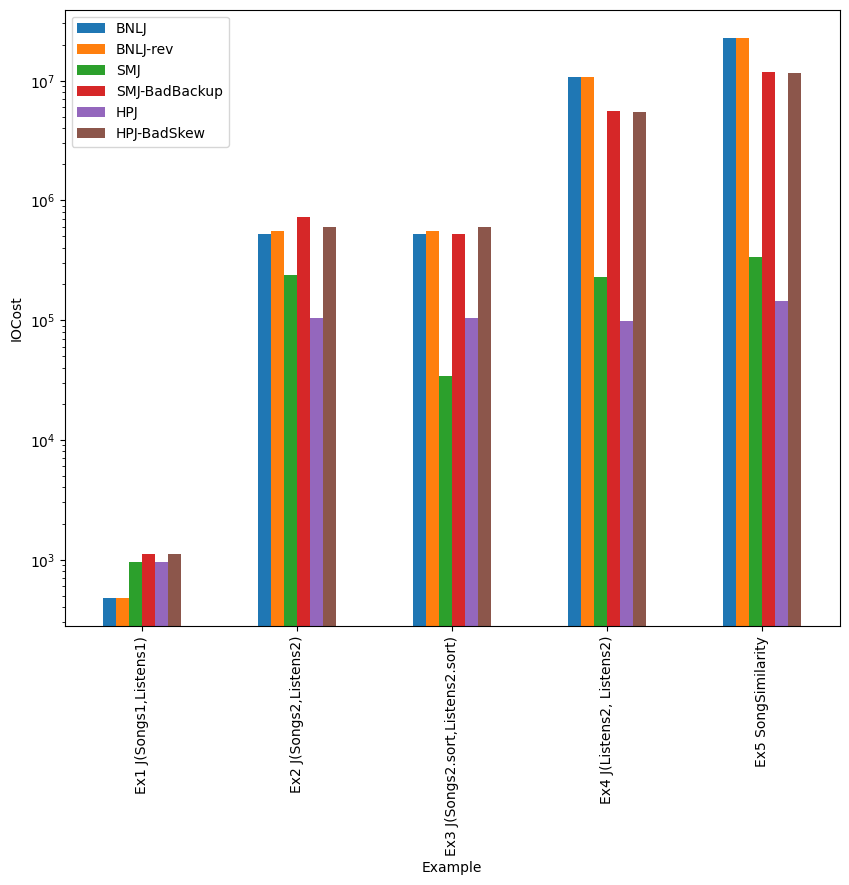

In [20]:
from IPython.display import display, HTML
import pandas as pd

def addToPd(desc, plans):
  return([desc, plans.get("BNLJ"), plans.get("BNLJ-rev"),
          plans.get("SMJ"), plans.get("SMJ-BadBackup"),
          plans.get("HPJ"), plans.get("HPJ-BadSkew"),
          plans.get("GroupBy-Sort"), plans.get("GroupBy-Hash"),
          plans.get("OUT"), plans.get("OUT-uniq")])

ex = []
db100 = DBOptimizer(100, 1.0, 1.0)
# Example1: Evaluate JOINing two non-big tables
Songs1 = Table(10.0*GB, 1024.0*Bytes)
Listens1 = Table(10.0*GB, 1024.0*Bytes)
ex.append(addToPd("Ex1 J(Songs1,Listens1)",
                  db100.EvaluateJoinPlans(Songs1, Listens1)))

# Example2: Evaluate JOINing two big tables
Songs2 = Table(100.0*GB, 1024.0*Bytes)
Listens2 = Table(2.0*TB, 1024.0*Bytes)
ex.append(addToPd("Ex2 J(Songs2,Listens2)",
                  db100.EvaluateJoinPlans(Songs2, Listens2)))

# Example3: Assume Songs2 and Listens2 are sorted.
Songs2.Sort()
Listens2.Sort()
ex.append(addToPd("Ex3 J(Songs2.sort,Listens2.sort)",
                  db100.EvaluateJoinPlans(Songs2, Listens2)))

# Example4: Self-join
Songs2.Reset()
Listens2.Reset()
ex.append(addToPd("Ex4 J(Listens2, Listens2)",
                  db100.EvaluateJoinPlans(Listens2, Listens2)))

# Example5: from Spotify song_similarity CTE
listens_rowSize = 32.0*Bytes
listens_numRows = pow(10.0, 11) # 100 billion listens
listens_sizeinMBs = listens_rowSize*listens_numRows/MB
Listens = Table(listens_sizeinMBs, 32.0*Bytes)
ex.append(addToPd("Ex5 SongSimilarity",
                  db100.EvaluateJoinPlans(Listens, Listens)))

pdf = pd.DataFrame(ex, columns= ["Example", "BNLJ", "BNLJ-rev", "SMJ",
                                 "SMJ-BadBackup", "HPJ", "HPJ-BadSkew",
                                 "GroupBy-Sort", "GroupBy-Hash",
                                 "OUT", "OUT-uniq"])

import matplotlib.pyplot as plt
%matplotlib inline
pdf.plot.bar(x='Example', y = ['BNLJ', 'BNLJ-rev', 'SMJ', 'SMJ-BadBackup',
                               'HPJ', 'HPJ-BadSkew',
                               'GroupBy-Sort', 'GroupBy-Hash', 'OUT', 'OUT-uniq'],
                               figsize=(10,8), logy=True)
plt.ylabel("IOCost")
plt.show()

OBSERVATIONS

In Example 1, BNLJ is cheaper than SMJ. Why? Songs1 and Listens1 (10 GBs) are pretty small vs B.(100 page = 100*64MBs = 6.4GBs). Intuitively, makes sense. That is, if the data mostly fits in RAM, BNLJ will JOIN in RAM, without any pre-processing (Sort or HP) overhead.

In other cases, we see SMJ and HPJ are doing better than BNLJ. Especially, when the number of pages in join tables is big compared to B. Of course, in the worst case, SMJ (with bad backbackup) or HPJ (with bad skew) could perform poorly. SMJ and HPJ do even better, if they were pre-sorted or pre-partitioned (perhaps for another query or index).

In practice, the query optimizer will evaluate the costs, and pick the algorithm with the least expected cost (e.g. based on prior history or statistics it maintains about the likelihood of duplicates.)

--------------------------------------------------------------------------------

Exercise 2 Problems

Consider Songs3=100GB and Listens3 = 1.0TB. Both have row size = 1024.0 Bytes. Let's explore the impact of different machine configurations on IO costs.

Machines have different RAM buffer sizes (e.g., 32 GBs to 640GBs). Also, when handling multiple parallel queries, query optimizers may use only a portion of the available RAM per query (e.g. 20% for one query, 60% for another, etc).
IOdevices often have different C_r and C_w costs. In some devices, C_w is 10x as much as C_r, and in some devices C_w is much faster than C_r.

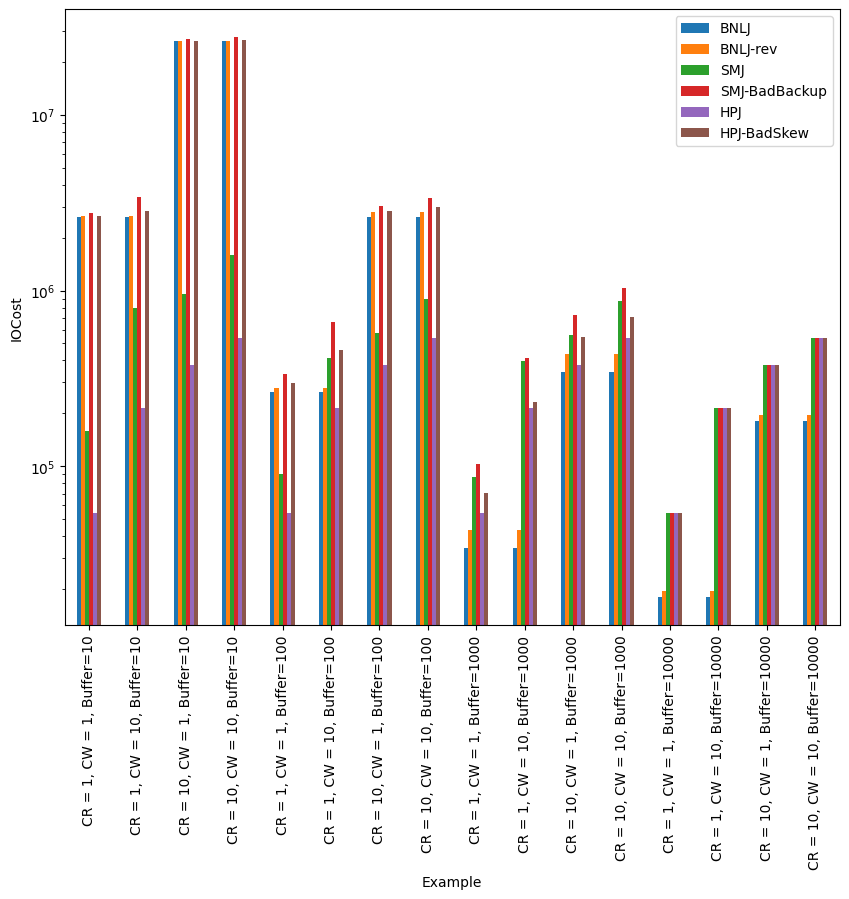

In [44]:
""" Problem 2.1:
Compute IOcosts of BNLJ, SMJ, HPJ for B = 10, 100, 1000, 10000, for different
values of C_r and C_w. Ignore OUT (cost of writing output) in these calculations.
What are the relative costs of SMJ and HPJ versus BNLJ?
"""

ex2 = []
Songs3 = Table(100.0*GB, 1024.0*Bytes)
Listens3 = Table(1.0*TB, 1024.0*Bytes)

DBOptimizerObjects= []

for B in [10, 100, 1000, 10000]:
    for CR in [1,10]:
        for CW in [1, 10]:
            dbo = DBOptimizer(B, CR, CW)
            ex2.append(addToPd("CR = "+str(CR)+", CW = "+str(CW)+", Buffer="+str(B),dbo.EvaluateJoinPlans(Songs3, Listens3)))

pdf = pd.DataFrame(ex2, columns= ["Example", "BNLJ", "BNLJ-rev", "SMJ",
                                 "SMJ-BadBackup", "HPJ", "HPJ-BadSkew",
                                 "GroupBy-Sort", "GroupBy-Hash",
                                 "OUT", "OUT-uniq"])

%matplotlib inline
pdf.plot.bar(x='Example', y = ['BNLJ', 'BNLJ-rev', 'SMJ', 'SMJ-BadBackup',
                               'HPJ', 'HPJ-BadSkew',
                               'GroupBy-Sort', 'GroupBy-Hash', 'OUT', 'OUT-uniq'],
                               figsize=(10,8), logy=True)
plt.ylabel("IOCost")
plt.show()

From the graph we can see that:
1. BNLJ is less when the buffer size is of a larger size.
2. SMJ and and HPJ are more costly as compared to BNLJ when the buffer is of a larger size and vice versa when the buffer size is of a smaller size.